In [160]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Input
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from mlp_explainer.synthetic_data import SyntheticData

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from pgmpy.estimators import PC, HillClimbSearch, GES
from networkx.drawing.nx_agraph import graphviz_layout

#### 1. Define Ground Truth Bayesian Network

In [341]:
identifier = 'experiment_1'
experiment = SyntheticData(identifier)

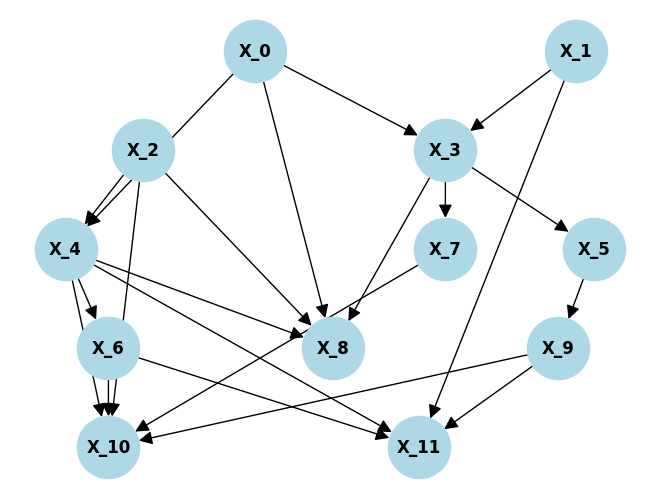

In [342]:
experiment.draw_network()

#### 2. Sample Sufficient Dataset From Ground Truth Bayesian Network

In [343]:
experiment.create_dataset()
experiment.save()

Aborting: experiment_1 dataset already exists.
Aborting: experiment_1 ground truth network already exists.


In [344]:
data = pd.read_csv(f'data/{identifier}_ground_data.csv')
data

,X_0,X_3,X_4,X_8,X_1,X_11,X_2,X_10,X_5,X_7,X_6,X_9
0,0.750165,1.785019,-0.888028,1.433829,1.557928,-1.290671,-1.525579,-0.473645,0.079971,1.410465,0.237174,-4.487023
1,-0.474873,-1.803973,0.052846,3.243156,3.182047,0.257442,-2.437506,-0.036942,2.225710,-1.255842,0.915549,-6.121457
2,0.162770,-1.982087,-0.613613,0.410640,3.128165,0.618413,-0.860671,-0.042913,-0.751101,0.417778,0.944707,-6.121450
3,1.828503,-2.270752,-5.642160,3.638501,-1.513359,-1.610955,-2.874271,-1.215246,0.884855,1.436632,-6.549039,1.464158
4,1.110116,-0.897406,-2.450025,2.106292,0.101102,0.260060,-1.795227,-0.760535,0.701033,-0.622367,-1.159809,1.454774
...,...,...,...,...,...,...,...,...,...,...,...,...
16379,-0.573055,1.016555,0.801469,0.341595,0.690390,0.510383,-0.809867,-0.601733,-0.211598,0.039443,3.132643,-1.263805
16380,-0.723023,-2.199313,2.257185,3.594207,1.933645,-1.020704,-2.740681,-0.313220,2.747566,0.936880,4.347454,-6.657429
16381,-0.667159,-1.708640,-1.425008,1.102886,1.435606,0.259247,-1.074941,-0.491883,0.468197,2.368711,-0.626016,-6.752284
16382,-0.220212,-2.539815,0.087206,1.766199,0.070661,-0.276629,-1.713071,-0.814531,0.917085,-0.860589,1.260215,1.589225


#### 3. Choose Target Variable From Bayesian Network Variables And Split Data

In [345]:
target_node = None
max_in_degree = -1
leaf_nodes = list(experiment.model.get_leaves())
in_degree_iterator = experiment.model.in_degree_iter()

for node, in_degree in in_degree_iterator:
    if node in leaf_nodes and in_degree > max_in_degree:
        target_node = node
        max_in_degree = in_degree

print(f'Target Node: {target_node}')

Target Node: X_10


In [346]:
X_columns = [column for column in data.columns.tolist() if column != target_node]

X = data[X_columns].values
y = data[target_node].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (13107, 11) (13107,)
Test shape: (3277, 11) (3277,)


#### 4. Data Preprocessing

In [347]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 5. Build And Train Model

In [348]:
model_filename = os.path.join("models", f"{identifier}_model.keras")
if os.path.exists(model_filename):
    print(f"Skip Stage 5 & 6: {identifier} model already exists.")

Skip Stage 5 & 6: experiment_1 model already exists.


In [119]:
model = Sequential([
    Input(shape = (X_scaled.shape[1],)),
    Dense(32, activation = 'relu'),
    Dense(32, activation = 'sigmoid'),
    Dense(8, activation = 'relu'),
    Dense(1)  
])

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse')

In [120]:
history = model.fit(X_scaled, y, epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0185 - val_loss: 0.0051
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0041 - val_loss: 0.0044
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0041 - val_loss: 0.0043
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 8/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 9/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 10/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 11/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 12/50
410/410 ━━━━━━━━━━━━

#### 6. Report and Save Model Performance

In [121]:
loss = model.evaluate(X, y)
predictions = model.predict(X)
r2 = r2_score(y, predictions)

print(f"R² score: {r2:.4f}")
print(f"Final loss: {loss}")

512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0038
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
R² score: 0.9588
Final loss: 0.003838282311335206


In [129]:
model_filename = os.path.join("models", f"{identifier}_model.keras")
model.save(model_filename)

#### 7. Save Random Instance To Explain

In [349]:
explaindata_filename = os.path.join("data", f"{identifier}_explaindata.npy")

if os.path.exists(explaindata_filename):
    print(f"Skip Stage 7: {identifier} explaindata already exists.")

Skip Stage 7: experiment_1 explaindata already exists.


In [145]:
X_test[0].shape

(11,)

In [146]:
num_rows = X_test.shape[0]
random_indices = np.random.choice(num_rows, size = 5, replace = False)
explaindata = X_test[random_indices]

In [148]:
np.save(explaindata_filename, explaindata)

#### 8. Data Generation

In [350]:
model = keras.models.load_model(model_filename)

In [351]:
def draw_network(model) -> None:

    DAG = nx.DiGraph()
    DAG.add_nodes_from(model.nodes())
    DAG.add_edges_from(model.edges())

    pos = graphviz_layout(DAG, prog="dot")
        
    nx.draw(
        DAG,
        pos,
        with_labels = True,
        node_size = 2000,
        node_color = "lightblue",
        arrowsize = 20,
        font_size = 12,
        font_weight = "bold"
    )

    plt.show()

In [377]:
def data_generation(input_datapoint, X_data, model, num_samples = 1000, scale = 1):
    '''
    Straight-forward data generation (without masks).
    '''
    
    prediction = model.predict(np.array([input_datapoint]))[0][0]
    empirical_covariance = np.cov(X_data, rowvar = False) / scale
    samples = np.random.multivariate_normal(mean = input_datapoint, cov = empirical_covariance, size = num_samples)

    predictions = []
    for i in range(num_samples):
        for j in range(len(samples[i])):
            if random.random() < 0.2:
                samples[i][j] = input_datapoint[j]
    sample_predictions = model.predict(samples).reshape(num_samples,)

    samples = samples - input_datapoint
    sample_predictions = sample_predictions - prediction
    
    return samples, sample_predictions

In [488]:
explain_data = np.load(explaindata_filename)
samples, sample_predictions = data_generation(explain_data[1], X, model, num_samples = 50, scale = 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


#### 9. Structure Learning

In [489]:
columns = data.columns.drop(target_node)
dataframe = pd.DataFrame(samples, columns = columns)
dataframe[target_node] = sample_predictions

In [490]:
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_array(
        estimated_model.to_undirected(), nodelist=nodes, weight=None
    )
    true_adj = nx.to_numpy_array(
        true_model.to_undirected(), nodelist=nodes, weight=None
    )

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_3': 'N', 'X_4': 'N', 'X_8': 'N', 'X_1': 'N', 'X_11': 'N', 'X_2': 'N', 'X_5': 'N', 'X_7': 'N', 'X_6': 'N', 'X_9': 'N', 'X_10': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_3': 'N', 'X_4': 'N', 'X_8': 'N', 'X_1': 'N', 'X_11': 'N', 'X_2': 'N', 'X_5': 'N', 'X_7': 'N', 'X_6': 'N', 'X_9': 'N', 'X_10': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_3': 'N', 'X_4': 'N', 'X_8': 'N', 'X_1': 'N', 'X_11': 'N', 'X_2': 'N', 'X_5': 'N', 'X_7': 'N', 'X_6': 'N', 'X_9': 'N', 'X_10': 'N'}


  0%|          | 0/10000 [00:00<?, ?it/s]

F1-score for the model skeleton:  0.45


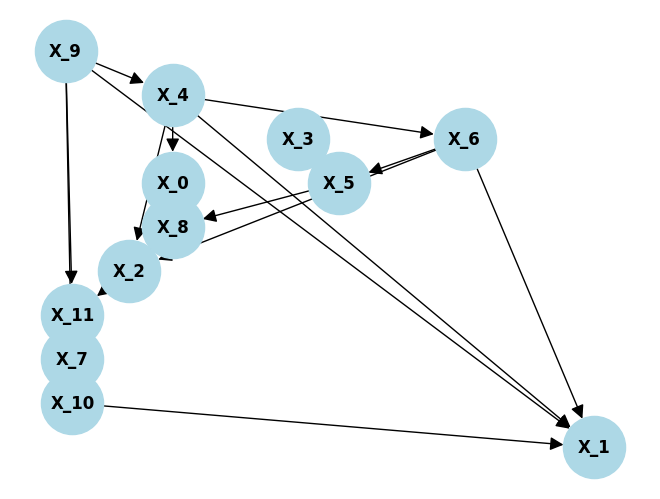

In [491]:
est = HillClimbSearch(data = dataframe)
estimated_model = est.estimate(scoring_method = "bic-g", max_indegree = 4, max_iter = int(1e4))
get_f1_score(estimated_model, experiment.model)
draw_network(estimated_model)

In [507]:
def markov_blanket(model, target):
    
    model_ = copy.deepcopy(model)
    blanket = model_.get_markov_blanket(target)

    print(f'Blanket: {blanket}')

    for node in list(model_.nodes()):
        if node not in blanket and node != target:
            model_.remove_node(node)

    return model_

Blanket: ['X_1', 'X_7', 'X_4', 'X_9', 'X_6']


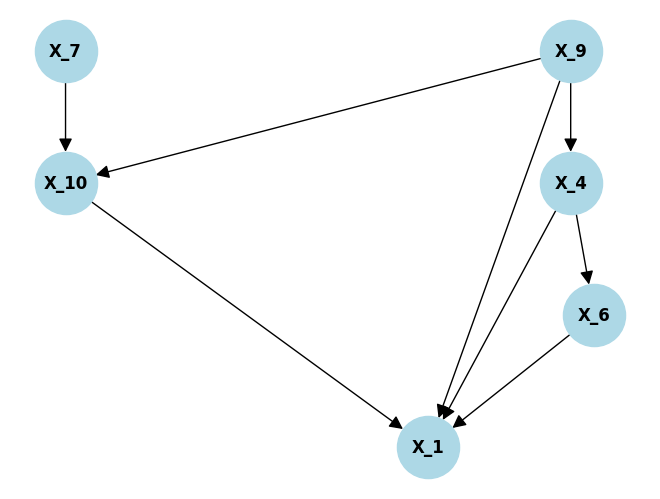

In [508]:
generated_blanket = markov_blanket(estimated_model, target_node)
draw_network(generated_blanket)

Blanket: ['X_7', 'X_4', 'X_9', 'X_2', 'X_6']


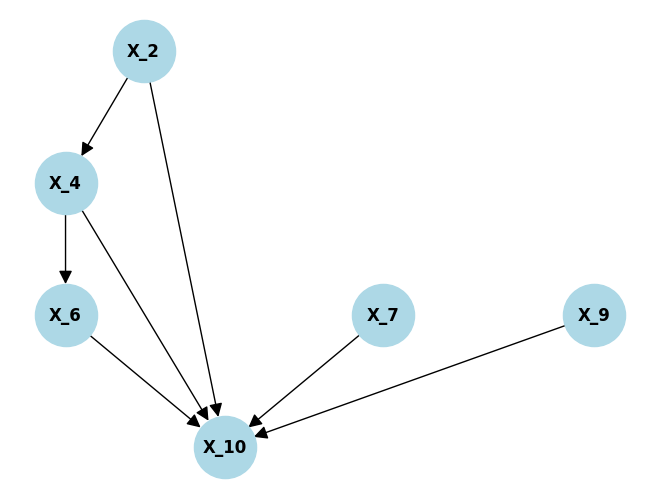

In [509]:
ground_blanket = markov_blanket(experiment.model, target_node)
draw_network(ground_blanket)